In [1]:
# -*- coding: utf-8 -*-

"""This file implements the graph generator for the problem. It is used to generate data for training, validation and testing.
"""

'This file implements the graph generator for the problem. It is used to generate data for training, validation and testing.\n'

In [2]:
import networkx as nx
import numpy as np
import random as r

In [181]:
def generate_pair_of_matching_graphs_for_nodes(current_G1, current_G2, num_nodes, node_attrs, edge_attrs, wn = 1, density = 0.5):
    """Inputs: current_G1, current_G2: current G1 and G2 graphs, the new graph is added to the current ones
               n - number of pairs of graphs to be generated
               num_nodes - number of nodes in a graph
               node_attrs - a dict of node attributes as stringsand their domains, 
                            the exact values of attributes are randomly generated
               edge_attrs - a dict of edge attributes as strings and their domains, 
                            the exact values of attributes are randomly generated
               wn - a parameter in [0,1] determining the significance in node similarity in generating the pairs, 1 if only node
                    attributes are considered(i.e. all nodes are the same, otherwise, each node has wn probability to change its
                    attributes)
               density - a parameter in [0,1] decides how dense the graph should be, on the premise that the graph is connected,
                         1 is fully connected and 0 is a spanning tree. A number between is the probability that an edge is added
                         between two nodes. The spanning tree is randomly generated.
       Return: one pair of matching graphs
       Strategy: If focusing on nodes, generate one graph first, use the nodes to generate a matching graph by randomly
                    connecting.
                 """
    
    g1 = nx.Graph()
    g2 = nx.Graph()
    
    if current_G1.nodes:
        n1 = r.sample(current_G1.nodes.data(),1)    # select a point of overlapping for the current graph and the new pair
        n2 = r.sample(current_G2.nodes.data(),1)
        g1.add_nodes_from(n1)
        g2.add_nodes_from(n2)
    
    ################################# 1. when focusing on nodes
    # generate random nodes
    if len(g1.nodes) > 0:     # no. of new nodes to be generated
        ni = num_nodes - 1
    else:
        ni = num_nodes
    for i in range(len(current_G1.nodes), len(current_G1.nodes) + ni):
        g1.add_node(i)
        for attr in node_attrs:
            g1.nodes[i][str(attr)] = r.choice(node_attrs[attr])
    
    g2.add_nodes_from(g1.nodes.data())
    for i in g2.nodes:
        for attr in node_attrs:
            if wn < r.uniform(0,1):
                g2.nodes[i][str(attr)] = r.choice(node_attrs[attr])
                
    connected_nodes = {list(g1.nodes)[0]}  # record currently connected nodes
    connected_nodes2 = {list(g2.nodes)[0]}  # record currently connected nodes
    # connect the nodes for g1
    while len(connected_nodes) < num_nodes:
        i = r.sample(connected_nodes, 1)[0]    
        choices = [j for j in list(g1.nodes) if j not in connected_nodes]
        if not choices:
            continue
        c = r.choice(choices)
        g1.add_edge(i,c)
        for attr in edge_attrs:
            g1.edges[i,c][str(attr)] = r.choice(edge_attrs[attr])
        connected_nodes.add(c)
        
    # add edges using density for g1
    for i in g1.nodes:
        for j in g1.nodes:
            if i != j and (i,j) not in g1.edges and (j,i) not in g1.edges:
                t = r.uniform(0,1)
                if t < density:
                    g1.add_edge(i,j)
                    for attr in edge_attrs:
                        g1.edges[i,j][str(attr)] = r.choice(edge_attrs[attr])
             
    # connect the nodes for g2
    while len(connected_nodes2) < num_nodes:
        i = r.sample(connected_nodes2, 1)[0]    
        choices = [j for j in list(g2.nodes) if j not in connected_nodes2]
        if not choices:
            continue
        c = r.choice(choices)
        g2.add_edge(i,c)
        for attr in edge_attrs:
            g2.edges[i,c][str(attr)] = r.choice(edge_attrs[attr])
        connected_nodes2.add(c)
    
    # add edges using density for g2
    for i in g2.nodes:
        for j in g2.nodes:
            if i != j and (i,j) not in g2.edges and (j,i) not in g2.edges:
                t = r.uniform(0,1)
                if t < density:
                    g2.add_edge(i,j)
                    for attr in edge_attrs:
                        g2.edges[i,j][str(attr)] = r.choice(edge_attrs[attr])
    
    # add the new graphs to the current aggregated graph
    current_G1.add_nodes_from(g1.nodes.data())
    current_G1.add_edges_from(g1.edges.data())
    current_G2.add_nodes_from(g2.nodes.data())
    current_G2.add_edges_from(g2.edges.data())
    
    return g1, g2, current_G1, current_G2

(NodeDataView({0: {'name': 'c', 'color': 'green'}, 1: {'name': 'a', 'color': 'red'}, 2: {'name': 'c', 'color': 'red'}, 3: {'name': 'b', 'color': 'black'}, 4: {'name': 'c', 'color': 'green'}}),
 EdgeView([(0, 4), (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 4), (3, 4)]),
 NodeDataView({0: {'name': 'c', 'color': 'green'}, 1: {'name': 'a', 'color': 'red'}, 2: {'name': 'c', 'color': 'red'}, 3: {'name': 'b', 'color': 'black'}, 4: {'name': 'c', 'color': 'green'}}),
 EdgeView([(0, 1), (0, 4), (0, 2), (0, 3), (1, 3), (1, 2), (2, 3), (2, 4), (3, 4)]))

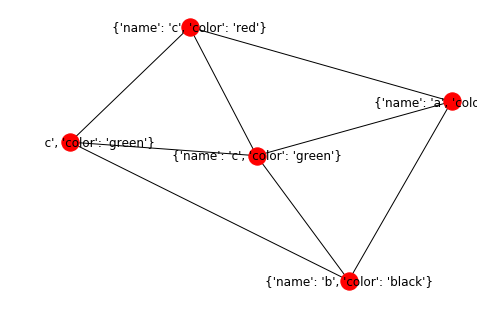

In [182]:
gt1 = nx.Graph()
gt2 = nx.Graph()
g1, g2, Gt1, Gt2 = generate_pair_of_matching_graphs_for_nodes(gt1,gt2, 5, {"name":["a","b","c"], "color":["red","black","green"]}, {"weight":[1,2,3,4,5]})
labels=dict((n,d) for n,d in g1.nodes.data())
nx.draw(g1, labels = labels, with_labels = True)
g1.nodes.data(), g1.edges, g2.nodes.data(), g2.edges

In [183]:
def generate_pair_of_matching_graphs_for_structure(current_G1, current_G2, num_nodes, node_attrs, edge_attrs, ws = 0.5, density = 0.5):
    """Inputs: current_G1, current_G2: current G1 and G2 graphs, the new graph is added to the current ones
               num_nodes - number of nodes in a graph
               node_attrs - a dict of node attributes as stringsand their domains, 
                            the exact values of attributes are randomly generated
               edge_attrs - a dict of edge attributes as strings and their domains, 
                            the exact values of attributes are randomly generated
               ws - a parameter in [0,1] determining the significance in structure similarity in generating the pairs, 1 if only node
                    attributes are considered
               density - a parameter in [0,1] decides how dense the graph should be, on the premise that the graph is connected,
                         1 is fully connected and 0 is a spanning tree. A number between is the probability that an edge is added
                         between two nodes. The spanning tree is randomly generated.
       Return: one pair of matching graphs
       Strategy: If focusing on structure, generate one graph first, then generate a similar structure, then add attributes
                to the nodes"""
    
    g1 = nx.Graph()
    g2 = nx.Graph()
    
    if current_G1.nodes:
        n1 = r.sample(current_G1.nodes.data(),1)    # select a point of overlapping for the current graph and the new pair
        n2 = r.sample(current_G2.nodes.data(),1)
        g1.add_nodes_from(n1)
        g2.add_nodes_from(n2)
        
    ################################# 2. When focusing on the structure
    # generate random nodes
    if len(g1.nodes) > 0:     # no. of new nodes to be generated
        ni = num_nodes - 1
    else:
        ni = num_nodes
    # generate random nodes
    for i in range(len(current_G1.nodes), len(current_G1.nodes) + ni):
        g1.add_node(i)
        for attr in node_attrs:
            g1.nodes[i][str(attr)] = r.choice(node_attrs[attr])
    
    connected_nodes = {list(g1.nodes)[0]}  # record currently connected nodes
    # connect the nodes for g1
    while len(connected_nodes) < num_nodes:
        i = r.sample(connected_nodes, 1)[0]    
        choices = [j for j in list(g1.nodes) if j not in connected_nodes]
        if not choices:
            continue
        c = r.choice(choices)
        g1.add_edge(i,c)
        for attr in edge_attrs:
            g1.edges[i,c][str(attr)] = r.choice(edge_attrs[attr])
        connected_nodes.add(c)
        
    # create a similar structure for g2 from g1
    g2.add_edges_from(g1.edges.data())
    
    # add edges using density for g1
    for i in g1.nodes:
        for j in g1.nodes:
            if i != j and (i,j) not in g1.edges and (j,i) not in g1.edges:
                t = r.uniform(0,1)
                if t < density:
                    g1.add_edge(i,j)
                    for attr in edge_attrs:
                        g1.edges[i,j][str(attr)] = r.choice(edge_attrs[attr])
     
    
    # create a similar structure for the additional edges for g2 from g1
    for e in g1.edges.data():
        if (e[0],e[1]) not in g2.edges.data():
            if r.uniform(0,1) < ws:
                g2.add_edges_from([e])
    
    # generate random nodes for g2
    for i in g2.nodes:
        for attr in node_attrs:
            g2.nodes[i][str(attr)] = r.choice(node_attrs[attr])
    
    # add the new graphs to the current aggregated graph
    current_G1.add_nodes_from(g1.nodes.data())
    current_G1.add_edges_from(g1.edges.data())
    current_G2.add_nodes_from(g2.nodes.data())
    current_G2.add_edges_from(g2.edges.data())
    
    return g1, g2, current_G1, current_G2

In [184]:
gt3 = nx.Graph()
gt4 = nx.Graph()
g1, g2, Gt3, Gt4 = generate_pair_of_matching_graphs_for_structure(gt3, gt4,5, {"name":["a","b","c"], "color":["red","black","green"]}, {"weight":[1,2,3,4,5]})
g1.nodes.data(), g1.edges, g2.nodes.data(), g2.edges

(NodeDataView({0: {'name': 'a', 'color': 'green'}, 1: {'name': 'b', 'color': 'red'}, 2: {'name': 'c', 'color': 'black'}, 3: {'name': 'c', 'color': 'red'}, 4: {'name': 'b', 'color': 'red'}}),
 EdgeView([(0, 3), (0, 2), (0, 1), (0, 4), (1, 2), (1, 4), (2, 4), (2, 3)]),
 NodeDataView({0: {'name': 'c', 'color': 'red'}, 3: {'name': 'a', 'color': 'green'}, 2: {'name': 'a', 'color': 'black'}, 1: {'name': 'c', 'color': 'red'}, 4: {'name': 'b', 'color': 'black'}}),
 EdgeView([(0, 3), (0, 2), (0, 1), (2, 4)]))

In [189]:
def generate_n_pairs_of_matching_graphs(n, num_nodes, node_attrs, edge_attrs, wn = 0.5, ws = 0.5, density = 0.5):
    """Inputs: n - number of pairs of graphs to be generated
               num_nodes - number of nodes in a graph
               node_attrs - a dict of node attributes as stringsand their domains, 
                            the exact values of attributes are randomly generated
               edge_attrs - a dict of edge attributes as strings and their domains, 
                            the exact values of attributes are randomly generated
               wn - a parameter in [0,1] determining the significance in node similarity in generating the pairs, 1 if only node
                    attributes are considered(i.e. all nodes are the same, otherwise, each node has wn probability to change its
                    attributes)
               ws - a parameter in [0,1] determining the significance in structure similarity in generating the pairs, 1 if only node
                    attributes are considered
               density - a parameter in [0,1] decides how dense the graph should be, on the premise that the graph is connected,
                         1 is fully connected and 0 is a spanning tree. A number between is the probability that an edge is added
                         between two nodes. The spanning tree is randomly generated.
       Return: G1 and G2, the aggregated graphs"""
    G1 = nx.Graph()
    G2 = nx.Graph()
    
    for i in range(n):
        g1,g2, G1, G2 = generate_pair_of_matching_graphs_for_nodes(G1, G2, num_nodes, node_attrs, edge_attrs, wn, density)
        print(i + 1, " pairs generated")
        
    return G1, G2

1  pairs generated
2  pairs generated
3  pairs generated
4  pairs generated
5  pairs generated
G1: 


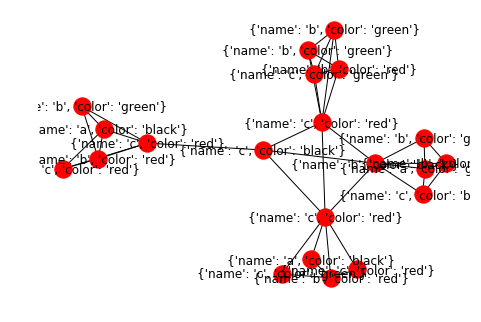

In [190]:
########################## Generate the graphs
n = 5
num_nodes = 5
node_attrs = {"name":["a","b","c"], "color":["red","black","green"]}
edge_attrs = {"weight":[1,2,3,4,5]}
wn = 0.5
ws = 0.5
density = 0.5
G1, G2 = generate_n_pairs_of_matching_graphs(n, num_nodes, node_attrs, edge_attrs, wn, ws, density)
labels1=dict((n,d) for n,d in G1.nodes.data())
print("G1: ")
nx.draw(G1, labels = labels1, with_labels = True)

G2: 


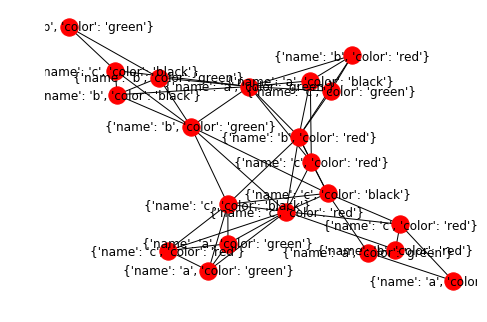

In [191]:
print("G2: ")
labels2=dict((n,d) for n,d in G2.nodes.data())
nx.draw(G2, labels = labels2, with_labels = True)